<a href="https://colab.research.google.com/github/sagardeshmukh81/Littlebits/blob/master/YT_PaliGemma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using PaliGemma with 🤗 transformers

Modified from the hugginface notebook

PaliGemma is a new vision language model released by Google. In this notebook, we will see how to use 🤗 transformers for PaliGemma inference.
First, install below libraries with update flag as we need to use the latest version of 🤗 transformers along with others.

In [ ]:
!pip install -q -U accelerate bitsandbytes git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 37.7 MB/s eta 0:00:00


PaliGemma requires users to accept Gemma license, so make sure to go to [the repository]() and ask for access. If you have previously accepted Gemma license, you will have access to this model as well. Once you have the access, login to Hugging Face Hub using `notebook_login()` and pass your access token by running the cell below.

In [ ]:
# from huggingface_hub import notebook_login

# notebook_login()


import os
from google.colab import userdata

os.environ["HF_TOKEN"] = userdata.get('HF_TOKEN')

In [ ]:
import torch
import numpy as np
from PIL import Image
import requests

input_text = "What color is the flower that bee is standing on?"
img_url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/bee.JPG?download=true"
input_image = Image.open(requests.get(img_url, stream=True).raw)

The image looks like below.

![](https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/bee.JPG?download=true)

You can load PaliGemma model and processor like below.

In [ ]:
from transformers import AutoTokenizer, PaliGemmaForConditionalGeneration, PaliGemmaProcessor
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_id = "google/paligemma-3b-mix-224"
model = PaliGemmaForConditionalGeneration.from_pretrained(model_id, torch_dtype=torch.bfloat16)
processor = PaliGemmaProcessor.from_pretrained(model_id)

config.json:   0%|          | 0.00/1.03k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/62.6k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/1.74G [00:00<?, ?B/s]

`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/699 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/40.0k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.26M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/607 [00:00<?, ?B/s]

The processor preprocesses both the image and text, so we will pass them.

In [ ]:
inputs = processor(text=input_text, images=input_image,
                  padding="longest", do_convert_rgb=True, return_tensors="pt").to("cuda")
model.to(device)
inputs = inputs.to(dtype=model.dtype)


We can pass in our preprocessed inputs.

In [ ]:
with torch.no_grad():
  output = model.generate(**inputs, max_length=496)

print(processor.decode(output[0], skip_special_tokens=True))

What color is the flower that bee is standing on?
pink


## Load model in 4-bit

You can also load model in 4-bit and 8-bit, which offers memory gains during inference.
First, initialize the `BitsAndBytesConfig`.

In [ ]:
from transformers import BitsAndBytesConfig
import torch
nf4_config = BitsAndBytesConfig(
   load_in_4bit=True,
   bnb_4bit_quant_type="nf4",
   bnb_4bit_use_double_quant=True,
   bnb_4bit_compute_dtype=torch.bfloat16
)


We will now reload the model but pass in above object as `quantization_config`.

In [ ]:
from transformers import AutoTokenizer, PaliGemmaForConditionalGeneration, PaliGemmaProcessor
import torch

device="cuda"
model_id = "google/paligemma-3b-mix-224"
model = PaliGemmaForConditionalGeneration.from_pretrained(model_id, torch_dtype=torch.bfloat16,
                                                          quantization_config=nf4_config, device_map={"":0})
processor = PaliGemmaProcessor.from_pretrained(model_id)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
with torch.no_grad():
  output = model.generate(**inputs, max_length=496)

print(processor.decode(output[0], skip_special_tokens=True))

What color is the flower that bee is standing on?
pink


In [ ]:
def query_paligemma(text, input_image):
    input_text = text
    input_image = input_image #Image.open(requests.get(img_url, stream=True).raw)

    inputs = processor(text=input_text, images=input_image,
                  padding="longest", do_convert_rgb=True, return_tensors="pt").to("cuda")

    inputs = inputs.to(dtype=model.dtype)

    with torch.no_grad():
        output = model.generate(**inputs, max_length=496)

    print(processor.decode(output[0], skip_special_tokens=True))



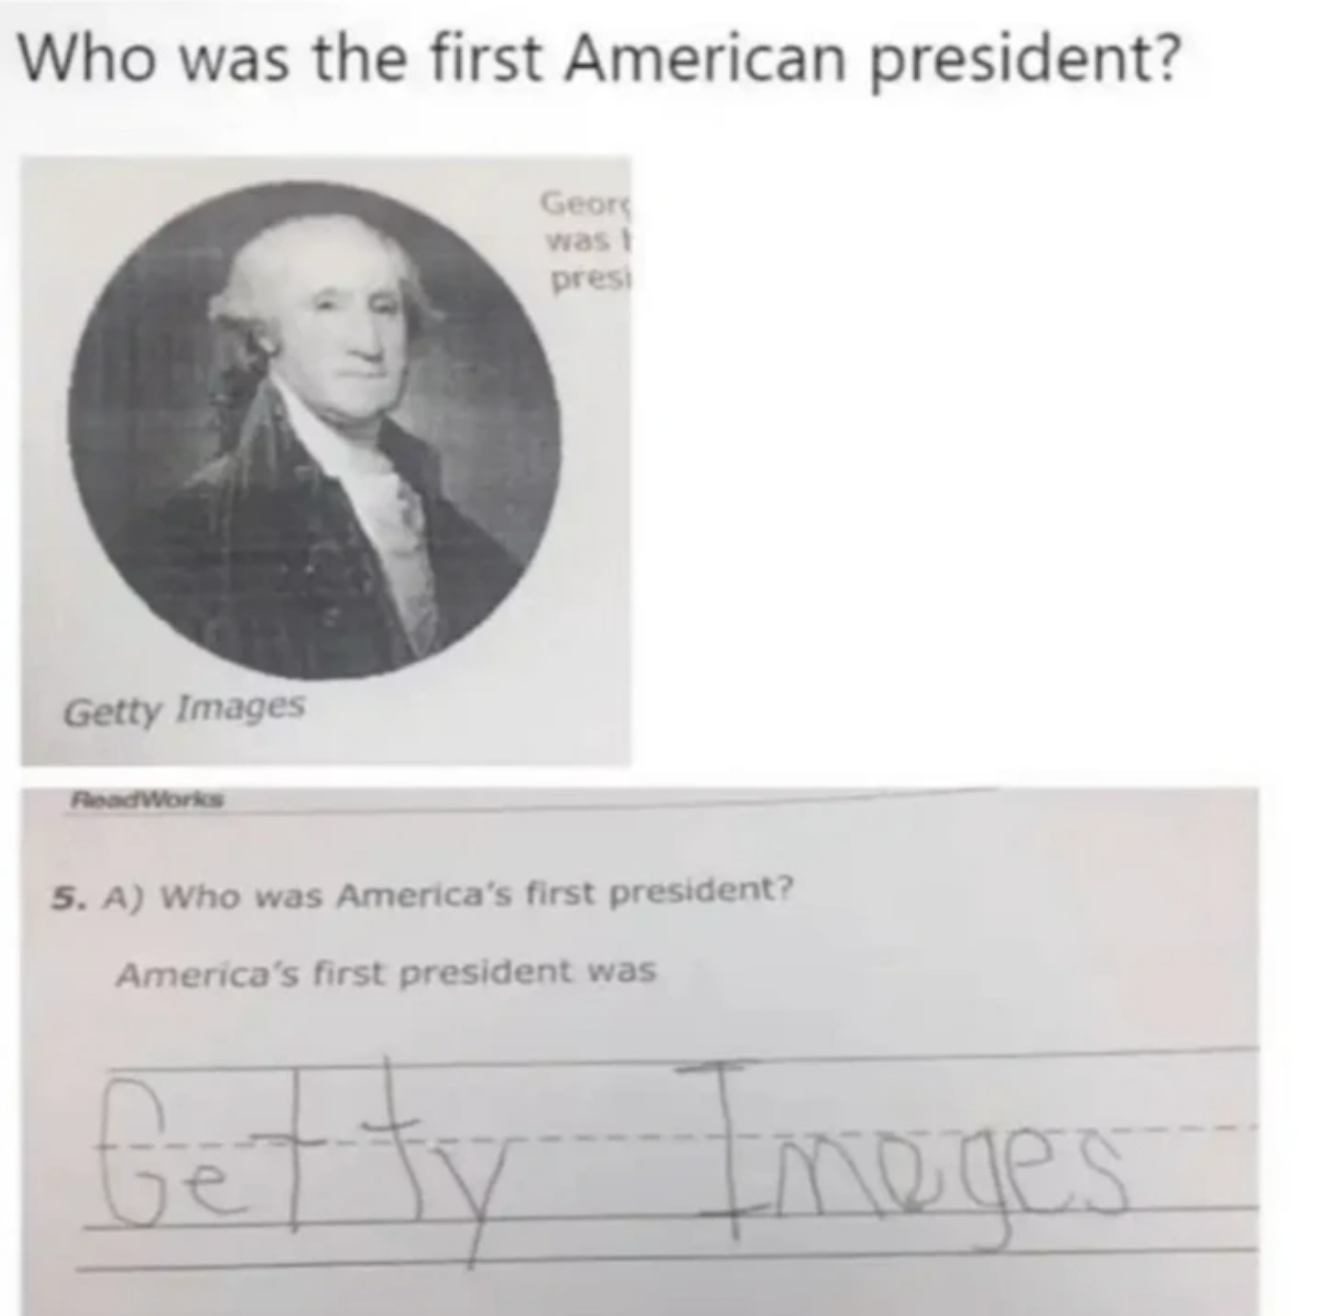

In [ ]:
img_url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/bee.JPG?download=true"


img_path = "/content/test_01.png"

input_image = Image.open(img_path).convert("RGB")
input_image

In [ ]:
query_paligemma("what is funny about this?", input_image)

what is funny about this?
Sorry, as a base VLM I am not trained to answer this question.


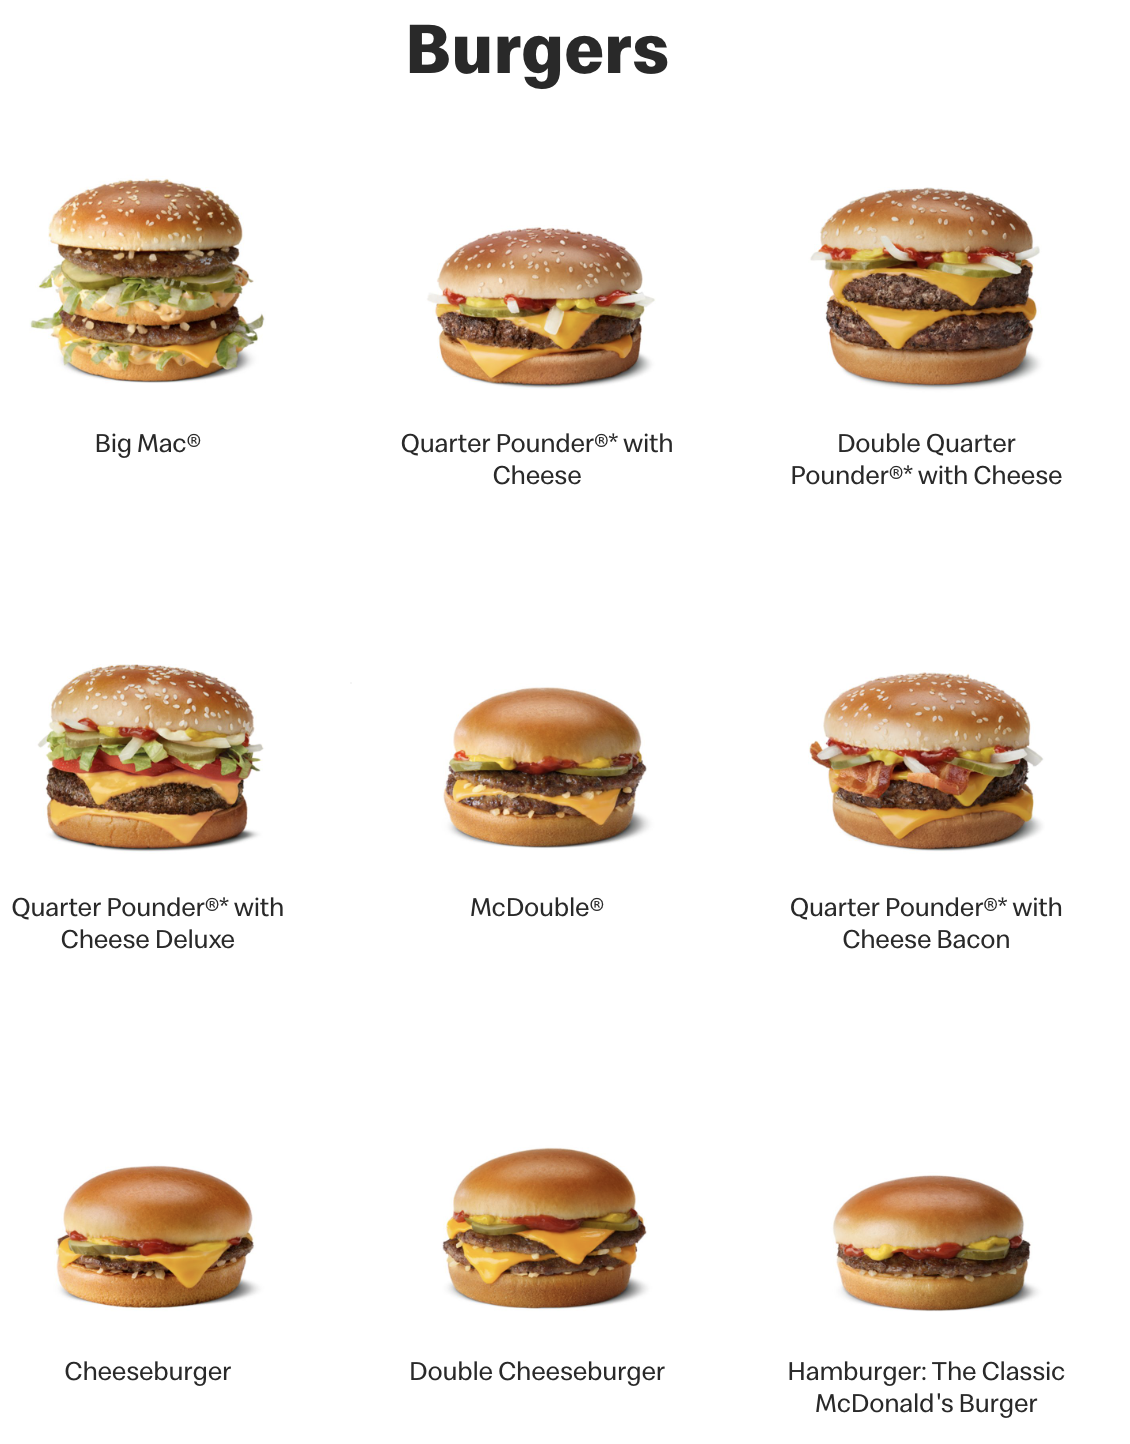

In [ ]:
img_path = "/content/test_02.png"

input_image = Image.open(img_path).convert("RGB")
input_image

In [ ]:
query_paligemma("what company makes these burgers?", input_image)

what company makes these burgers?
mcdonalds
